## Specify key parameters

In [ ]:
# parameters
# use num_labels = 3 if using positive for 0, negative for 1, neutral for 2
# use num_labels = 2 if using positive for 0, negative for 1
num_labels = 2

# input file name from financial phrasebank data
filename = 'Sentences_50Agree.txt'

# The DataLoader needs to know our batch size for training, For fine-tuning 
# BERT on a specific task, Devlin et. al. recommend a batch size of 16 or 32.
batch_size = 32

# maximum sequence length. use EDA and look at results to set this parameter
max_seq_length = 128

In [ ]:
!pip install transformers
# !pip install wget

     |████████████████████████████████| 2.2MB 6.0MB/s 
     |████████████████████████████████| 870kB 22.6MB/s 
     |████████████████████████████████| 3.3MB 27.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e76241d83d3f1e69b4015852460614c617ed5be8dfb5f2ba4386a732f08d80b3
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
# import modules

import tensorflow as tf
from keras import backend as K
import time
import datetime
import random
import numpy as np
import pandas as pd
# import wget
import os
import itertools
import collections
from transformers import BertTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold

import torch
from torch import nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torchvision import transforms, utils, datasets
from transformers import BertForSequenceClassification, AdamW, BertConfig

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If a GPU is available
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If no GPU is available
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")    

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data preprocessing

In [ ]:
# function to read in filename and create a list with sentences and a list with labels
# these are then used to create pandas dataframe for train and test data. 

def read_data(filename, num_labels):

  s2_train = []
  l2_train = []
  s2_test = []
  l2_test = []

  s3_train = []
  l3_train = []
  s3_test = []
  l3_test = []

  fname = '/content/drive/My Drive/data/' + filename 
  with open(fname, 'r', encoding='cp1252') as f:  
    lines = f.readlines()
    random.shuffle(lines)

    split_ratio = 0.9 # 90% data used for train and dev, 10% is held-out
    train_size = int(split_ratio * len(lines))
    test_size = len(lines) - train_size

    lines_train = random.sample(lines, train_size)
    lines_test = list((collections.Counter(lines)-collections.Counter(lines_train)).elements())

    if num_labels == 2:
      for line in lines_train:
        line_split = line.split('@')
        if line_split[-1][:-1] != 'neutral':
          s2_train.append(line_split[:-1])
          l2_train.append(line_split[-1][:-1])    

      for line in lines_test:
        line_split = line.split('@')
        if line_split[-1][:-1] != 'neutral':
          s2_test.append(line_split[:-1])
          l2_test.append(line_split[-1][:-1])    

      sentences_train = list(itertools.chain(*s2_train))
      labels_train = []

      sentences_test = list(itertools.chain(*s2_test))
      labels_test = []

      for label in l2_train:
        if label == 'positive':
          labels_train.append(0)
        elif label == 'negative':
          labels_train.append(1)

      for label in l2_test:
        if label == 'positive':
          labels_test.append(0)
        elif label == 'negative':
          labels_test.append(1)

      df_train = pd.DataFrame(list(zip(sentences_train, labels_train)),
                              columns=['sentences_train', 'labels_train'])

      df_test = pd.DataFrame(list(zip(sentences_test, labels_test)),
                             columns=['sentences_test', 'labels_test'])
 
    elif num_labels == 3:
      for line in lines_train:
        line_split = line.split('@')
        s3_train.append(line_split[:-1])
        l3_train.append(line_split[-1][:-1])    

      for line in lines_test:
        line_split = line.split('@')
        s3_test.append(line_split[:-1])
        l3_test.append(line_split[-1][:-1])

      sentences_train = list(itertools.chain(*s3_train))
      labels_train = []

      sentences_test = list(itertools.chain(*s3_test))
      labels_test = []

      for label in l3_train:
        if label == 'positive':
          labels_train.append(0)
        elif label == 'negative':
          labels_train.append(1)
        elif label == 'neutral':
          labels_train.append(2)

      for label in l3_test:
        if label == 'positive':
          labels_test.append(0)
        elif label == 'negative':
          labels_test.append(1)
        elif label == 'neutral':
          labels_test.append(2)

      df_train = pd.DataFrame(list(zip(sentences_train, labels_train)),
                              columns=['sentences_train', 'labels_train'])

      df_test = pd.DataFrame(list(zip(sentences_test, labels_test)),
                             columns=['sentences_test', 'labels_test'])

  return df_train, df_test

In [ ]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# calculate the max number of tokens in a sentence. 
def get_max_length(df):

  max_len = 0
  # For every sentence
  for sent in df['sentences_train']:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  return max_len

In [ ]:
# create train and test datasets
df_train, df_test = read_data(filename, num_labels)

sentences_train, labels_train = df_train['sentences_train'], df_train['labels_train']
sentences_test, labels_test = df_test['sentences_test'], df_test['labels_test']

print('number of train examples:', len(sentences_train) )
print('number of test examples:', len(sentences_test) )

if num_labels == 2:
  print('pos_train', len(df_train[df_train['labels_train']==0]))
  print('neg_train', len(df_train[df_train['labels_train']==1]))
  print('pos_test', len(df_test[df_test['labels_test']==0]))
  print('neg_test', len(df_test[df_test['labels_test']==1]))

elif num_labels == 3:
  print('pos_train', len(df_train[df_train['labels_train']==0]))
  print('neg_train', len(df_train[df_train['labels_train']==1]))
  print('neu_train', len(df_train[df_train['labels_train']==2]))
  print('pos_test', len(df_test[df_test['labels_test']==0]))
  print('neg_test', len(df_test[df_test['labels_test']==1]))
  print('neu_test', len(df_test[df_test['labels_test']==2]))


number of train examples: 1767
number of test examples: 200
pos_train 1213
neg_train 554
pos_test 150
neg_test 50


In [ ]:
# max_len_train = get_max_length(df_train)
# max_len_test = get_max_length(df_test)

# print('Max sentence length: ', max_len_train, max_len_test)

In [ ]:
df_train

,sentences_train,labels_train
0,The steelmaker said that the drop in profit wa...,1
1,Finnish Bank of +àland 's consolidated net ope...,0
2,The agreement will provide The Switch with dou...,0
3,Sales of clothing developed best .,0
4,The executive group will participate in the ad...,0
...,...,...
1762,The production is to be liquidated before June...,1
1763,Possible personnel reductions concern approxim...,1
1764,"Previously , the company had guided for EBIT a...",0
1765,`` Our extensive co-operation will also bolste...,0


In [ ]:
# Print the original sentence.
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  The steelmaker said that the drop in profit was explained by the continuing economic uncertainty , mixed with the current drought in bank lending , resulting in a decline in demand for its products as customers find it increasingly difficult to fund operations .
Tokenized:  ['the', 'steel', '##maker', 'said', 'that', 'the', 'drop', 'in', 'profit', 'was', 'explained', 'by', 'the', 'continuing', 'economic', 'uncertainty', ',', 'mixed', 'with', 'the', 'current', 'drought', 'in', 'bank', 'lending', ',', 'resulting', 'in', 'a', 'decline', 'in', 'demand', 'for', 'its', 'products', 'as', 'customers', 'find', 'it', 'increasingly', 'difficult', 'to', 'fund', 'operations', '.']
Token IDs:  [1996, 3886, 8571, 2056, 2008, 1996, 4530, 1999, 5618, 2001, 4541, 2011, 1996, 5719, 3171, 12503, 1010, 3816, 2007, 1996, 2783, 14734, 1999, 2924, 18435, 1010, 4525, 1999, 1037, 6689, 1999, 5157, 2005, 2049, 3688, 2004, 6304, 2424, 2009, 6233, 3697, 2000, 4636, 3136, 1012]


In [ ]:
## Motivated by Chris McCormick's tutorial: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

input_ids = []
attention_masks = []

# loop over sentences
for sent in sentences_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = max_seq_length,               # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                  )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (0 for padding and 1 for non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_train[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The steelmaker said that the drop in profit was explained by the continuing economic uncertainty , mixed with the current drought in bank lending , resulting in a decline in demand for its products as customers find it increasingly difficult to fund operations .
Token IDs: tensor([  101,  1996,  3886,  8571,  2056,  2008,  1996,  4530,  1999,  5618,
         2001,  4541,  2011,  1996,  5719,  3171, 12503,  1010,  3816,  2007,
         1996,  2783, 14734,  1999,  2924, 18435,  1010,  4525,  1999,  1037,
         6689,  1999,  5157,  2005,  2049,  3688,  2004,  6304,  2424,  2009,
         6233,  3697,  2000,  4636,  3136,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 split of train into train and dev. use cross-dev later
data_size = len(dataset)
train_size = int(0.9 * data_size)
dev_size = data_size - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, dev_dataset = random_split(dataset, [train_size, dev_size])

print('{:>5,} train samples'.format(train_size))
print('{:>5,} dev samples'.format(dev_size))

1,590 train samples
  177 dev samples


In [ ]:
# Create the DataLoaders for our training and dev sets. We'll take training samples in random order.
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# For dev order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=batch_size)

# Model set-up

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
# num_labels = 2 if positive, negative
# num_labels = 3 if positive, negative, neutral
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels = num_labels, # number of classes
                                                      output_attentions = False, 
                                                      output_hidden_states = False, 
                                                     )

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. higher epochs may over-fit the training data.
epochs = 4

# number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# Helper Functions

In [ ]:
def format_time(elapsed):
    # Takes a time in seconds and returns a string hh:mm:ss. Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Function to calculate the accuracy
def my_metrics(preds, labels, num_labels):

    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()
    accuracy = np.sum(y_pred == y_true) / len(y_true)

    return accuracy

# Training


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:16.

  Average training loss: 0.4687
  Training epoch took: 0:00:20

Running Validation...
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.80      1.00      0.89         8

    accuracy                           0.94        32
   macro avg       0.90      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32

[[22  2]
 [ 0  8]]
sentence [ C L S ] t h e c o m p a n y s t i l l e x p e c t s i t s t u r n o v e r i n 2 0 1 0 t o s l i g h t l y i n c r e a s e f r o m t h e l e v e l o f 2 0 0 9 , a d d i n g t h a t ` ` m a r k e t p r e d i c t # # a b i l i t y i s s t i l l t o o p o o r f o r t r u s t # # w o r t h y f o r e c a s t # # s o n t h e m a r k e t d e v e l o p m e n t o f t h e c o n t r a c t m a n u f a c t u r i n g b u s i n e s s d u r i n g t h e c u r r e n t y e a r ' ' 

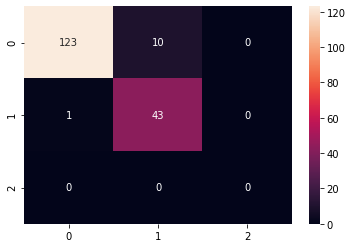

len dataloader 6
  Accuracy: 0.94
  avg my accuracy 0.94
  Validation Loss: 0.1824
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:16.

  Average training loss: 0.1326
  Training epoch took: 0:00:19

Running Validation...
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.80      1.00      0.89         8

    accuracy                           0.94        32
   macro avg       0.90      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32

[[22  2]
 [ 0  8]]
sentence [ C L S ] t h e c o m p a n y s t i l l e x p e c t s i t s t u r n o v e r i n 2 0 1 0 t o s l i g h t l y i n c r e a s e f r o m t h e l e v e l o f 2 0 0 9 , a d d i n g t h a t ` ` m a r k e t p r e d i c t # # a b i l i t y i s s t i l l t o o p o o r f o r t r u s t # # w o r t h y f o r e c a s t # # s o n t h e m a r k e t d e v e l o p m e n t o 

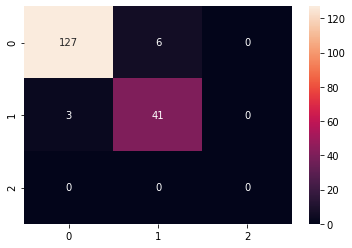

len dataloader 6
  Accuracy: 0.95
  avg my accuracy 0.95
  Validation Loss: 0.1409
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:16.

  Average training loss: 0.0715
  Training epoch took: 0:00:19

Running Validation...
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.80      1.00      0.89         8

    accuracy                           0.94        32
   macro avg       0.90      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32

[[22  2]
 [ 0  8]]
sentence [ C L S ] t h e c o m p a n y s t i l l e x p e c t s i t s t u r n o v e r i n 2 0 1 0 t o s l i g h t l y i n c r e a s e f r o m t h e l e v e l o f 2 0 0 9 , a d d i n g t h a t ` ` m a r k e t p r e d i c t # # a b i l i t y i s s t i l l t o o p o o r f o r t r u s t # # w o r t h y f o r e c a s t # # s o n t h e m a r k e t d e v e l o p m e n t o 

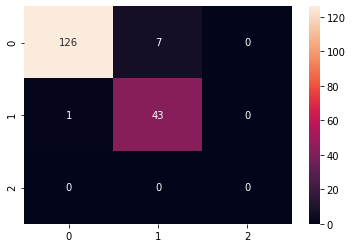

len dataloader 6
  Accuracy: 0.96
  avg my accuracy 0.96
  Validation Loss: 0.1658
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:16.

  Average training loss: 0.0426
  Training epoch took: 0:00:19

Running Validation...
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.80      1.00      0.89         8

    accuracy                           0.94        32
   macro avg       0.90      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32

[[22  2]
 [ 0  8]]
sentence [ C L S ] t h e c o m p a n y s t i l l e x p e c t s i t s t u r n o v e r i n 2 0 1 0 t o s l i g h t l y i n c r e a s e f r o m t h e l e v e l o f 2 0 0 9 , a d d i n g t h a t ` ` m a r k e t p r e d i c t # # a b i l i t y i s s t i l l t o o p o o r f o r t r u s t # # w o r t h y f o r e c a s t # # s o n t h e m a r k e t d e v e l o p m e n t o 

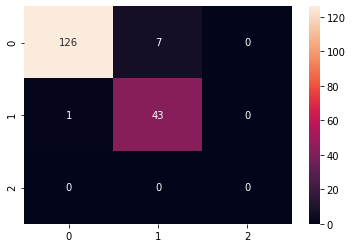

len dataloader 6
  Accuracy: 0.96
  avg my accuracy 0.96
  Validation Loss: 0.1637
  Validation took: 0:00:02

Training complete!
Total training took 0:01:25 (h:mm:ss)


In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and dev loss, 
# dev accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. 
    model.train()

    # loop over each batch
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack training batch from dataloader and copy each tensor to the GPU 
        # using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass 
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function returns the value from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               dev
    # ========================================
    # After the completion of each training epoch, check dev metrics

    print("")
    print("Running dev...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dev_dataloader:
        
        # Unpack batch from dataloader and copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to construct the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the dev loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        y_pred = np.argmax(logits, axis=1).flatten()
        y_true = label_ids.flatten()

        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true, y_pred))

        d = {}
        for i in range(len(label_ids)):
          # x is actual label, y is predicted label
          x = label_ids[i]
          y = np.argmax(logits, axis=1).flatten()[i]
          z = tokenizer.convert_ids_to_tokens(b_input_ids[i])
          merged = list(itertools.chain(*z))
          d[i] = ' '.join(merged)
          
          print('sentence', d[i], '\n')
          print('true label, pred label', x, y)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.

        total_eval_accuracy += my_metrics(logits, label_ids, num_labels)

    # Report the final accuracy for this dev run.
    n_dev = len(dev_dataloader)

    avg_dev_accuracy = total_eval_accuracy / n_dev

    print("  Accuracy: {0:.2f}".format(avg_dev_accuracy))

    # Calculate the average loss over all of the batches.
    avg_dev_loss = total_eval_loss / n_dev
    
    # Measure how long the dev run took.
    dev_time = format_time(time.time() - t0)
    
    print("  dev loss: {0:.4f}".format(avg_dev_loss))
    print("  dev took: {:}".format(dev_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'train loss': avg_train_loss,
            'dev loss': avg_dev_loss,
            'dev Accur.': avg_dev_accuracy,
            'train Time': training_time,
            'dev Time': dev_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,train Loss,dev Loss,dev Accur.,dev my Accur.,dev precision,dev recall,dev f1_score,tp,fp,fn,tn,train Time,dev Time
epoch,,,,,,,,,,,,,
1,0.469,0.182,0.943,0.943,0.993,0.932,0.961,20.500,0.167,1.667,7.167,0:00:20,0:00:02
2,0.133,0.141,0.953,0.953,0.979,0.960,0.969,21.167,0.500,1.000,6.833,0:00:19,0:00:02
3,0.072,0.166,0.958,0.958,0.993,0.953,0.972,21.000,0.167,1.167,7.167,0:00:19,0:00:02
4,0.043,0.164,0.958,0.958,0.993,0.953,0.972,21.000,0.167,1.167,7.167,0:00:19,0:00:02


In [ ]:
print(df_stats.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrll}
\toprule
 train Loss &  dev Loss &  dev Accur. &  dev my Accur. &  dev precision &  dev recall &  dev f1\_score &      tp &     fp &     fn &     tn & train Time & dev Time \\
      0.469 &     0.182 &       0.943 &          0.943 &          0.993 &       0.932 &         0.961 &  20.500 &  0.167 &  1.667 &  7.167 &    0:00:20 &  0:00:02 \\
\midrule
      0.133 &     0.141 &       0.953 &          0.953 &          0.979 &       0.960 &         0.969 &  21.167 &  0.500 &  1.000 &  6.833 &    0:00:19 &  0:00:02 \\
      0.072 &     0.166 &       0.958 &          0.958 &          0.993 &       0.953 &         0.972 &  21.000 &  0.167 &  1.167 &  7.167 &    0:00:19 &  0:00:02 \\
      0.043 &     0.164 &       0.958 &          0.958 &          0.993 &       0.953 &         0.972 &  21.000 &  0.167 &  1.167 &  7.167 &    0:00:19 &  0:00:02 \\
\bottomrule
\end{tabular}



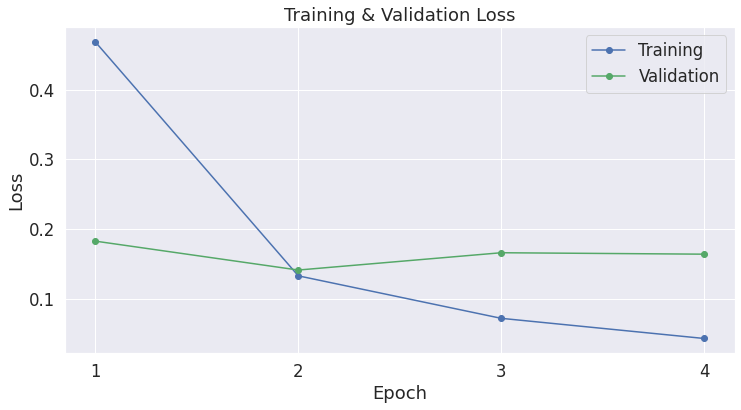

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['train loss'], 'b-o', label="Training")
plt.plot(df_stats['dev loss'], 'g-o', label="dev")

# Label the plot.
plt.title("Training & dev loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_seq_length,  # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Create the DataLoader.
test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 200 test sentences...
    DONE.


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [ ]:
n_tot = len(df_test.labels_test)
if num_labels == 2:
  n_pos = len(df_test[df_test.labels_test == 0])
  n_neg = len(df_test[df_test.labels_test == 1])
  print('positive samples: %d of %d (%.2f%%)' % (n_pos, n_tot, n_pos/n_tot * 100.0))
  print('negative samples: %d of %d (%.2f%%)' % (n_neg, n_tot, n_neg/n_tot * 100.0))

elif num_labels == 3:
  n_pos = len(df_test[df_test.labels_test == 0])
  n_neg = len(df_test[df_test.labels_test == 1])
  n_neu = len(df_test[df_test.labels_test == 2])
  print('positive samples: %d of %d (%.2f%%)' % (n_pos, n_tot, n_pos/n_tot * 100.0))
  print('negative samples: %d of %d (%.2f%%)' % (n_neg, n_tot, n_neg/n_tot * 100.0))
  print('neutral samples: %d of %d (%.2f%%)' % (n_neu, n_tot, n_neu/n_tot * 100.0))

else: 
  'enter correct value of num_labels'  

positive samples: 150 of 200 (75.00%)
negative samples: 50 of 200 (25.00%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  # print(i, true_labels[i], pred_labels_i)
  # print(i, true_labels[i]-pred_labels_i)

  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
df_test

,sentences_test,labels_test
0,It will focus on improving its profitability n...,0
1,"Furthermore , Bunge will also sign a licensing...",0
2,"According to Swedish authorities , traces of t...",1
3,Finnish retailer Stockmann has won approval fr...,0
4,To ensure low operational cost for radio netwo...,0
...,...,...
195,Revenue grew 12 percent to ( x20ac ) 3.6 bill...,0
196,"So far , Mr. Galvan he has been able to avoid ...",0
197,Last year 's net sales rose to EUR 68.3 millio...,0
198,Vaisala also said it expects net sales of EUR ...,0


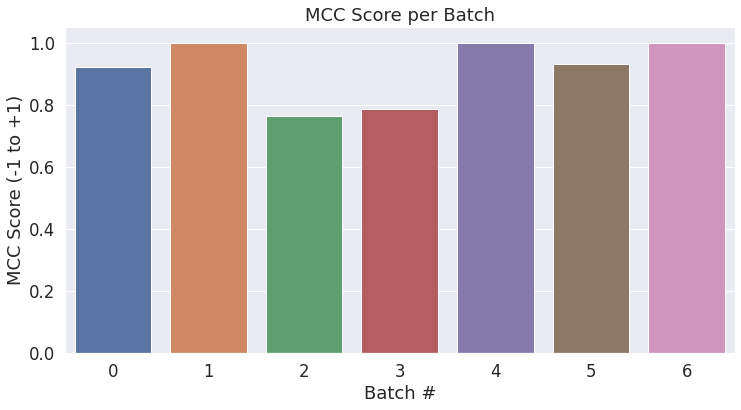

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
conf_mat_list = confusion_matrix(flat_true_labels, flat_predictions)
conf_mat_test = pd.DataFrame(conf_mat_list)

print(classification_report(flat_true_labels, flat_predictions))
print(confusion_matrix(flat_true_labels, flat_predictions))
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       0.96      0.90      0.93        50

    accuracy                           0.96       200
   macro avg       0.96      0.94      0.95       200
weighted avg       0.96      0.96      0.96       200

[[148   2]
 [  5  45]]
Total MCC: 0.906


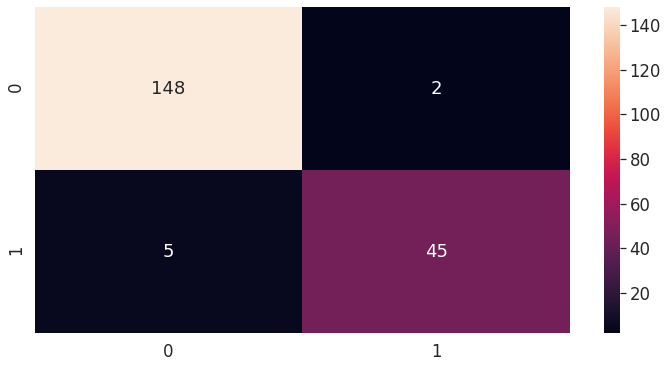

In [ ]:
sns.heatmap(conf_mat_test, annot=True, fmt="d")
plt.show()

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
# Copy the model files to Google Drive.
!cp -r ./model_save/ '/content/drive/My Drive/data/'

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# # Copy the model to the GPU.
# model.to(device)